<a href="https://colab.research.google.com/github/Pseudophoenix/Sentiment-Analysis/blob/main/Sentiment_Analysis_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow_datasets as tfds, re, numpy as np
import os, string, tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input, Embedding, SimpleRNN, Dense, Bidirectional, LSTM, Dropout

### Data Preparation

In [10]:
train_ds,val_ds,test_ds=tfds.load("imdb_reviews",split=['train','test[:50%]','test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OBBRN1_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OBBRN1_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OBBRN1_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


The `take(n)` method efficiently retrieves a small subset (n elements) from a dataset without loading the entire dataset, making it useful for quick debugging or sampling.

`take(5):` Streams only 5 batches/samples, avoiding full dataset iteration.

In [11]:
for review,label in train_ds.take(5):
  print(len(tf.strings.split(review,sep=" ")))
  print(review)
  print(label)

116
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
112
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howe

As shown above two sentiments positive and negative for a given review

    "<[^>]+>" is a regular expression that matches HTML tags:

    < matches the opening angle bracket

    [^>]+ matches one or more characters that are NOT closing angle brackets

    > matches the closing angle bracket

    Pattern: "[%s]" % re.escape(string.punctuation) creates a regex pattern that matches any punctuation character

    string.punctuation is a string containing all common punctuation marks (!"#$%&'()*+,-./:;<=>?@[\]^_{|}~`)

    re.escape() ensures special regex characters are properly escaped

    The [ ] makes it a character class, meaning "match any of these characters"

In [12]:
def standardization(input_data):
  """
  Input: raw reviews may be fetched from any API, website scrapped, or anything else
  Output: standardized reviews
  """
  lowercase=tf.strings.lower(input_data) # convert to lowercase
  no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","") # replace html tags with nothing
  output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"") # replace punctuation symbols with "" nothing
  return output

In [13]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [14]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

Tokenization and numericalization have been wrapped into just one layer of `tf` `TextVectorization layer`

We have created our custom standardize function, we could have used 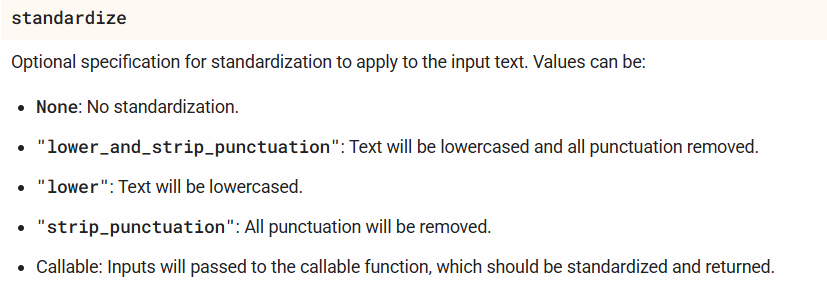

In [15]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    # output_mode='int',
    output_mode='multi_hot' #-> ONE HOT REPRESENTATION
    # output_sequence_length=SEQUENCE_LENGTH
)

In [16]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    # output_mode='multi_hot' #-> ONE HOT REPRESENTATION
    output_sequence_length=SEQUENCE_LENGTH
)

To simply not guess the VOCAB_SIZE and SEQUENCE_LENGTH take a deeper look into the dataset

In [17]:
lengths=[] # length of each reviews that is the number of words
words=[] # will contain the vocabulary words from the first 10 reviews
for review,label in train_ds.take(100):
    # for word in tf.strings.split(review,sep=" "):
    #   if word in words:
    #     pass
    #   else:
    #     words.append(word)
    lengths.append(len(tf.strings.split(review,sep=" ")))

In [18]:
print(lengths)#,words

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127, 164, 277, 545, 141, 332, 84, 312, 420, 267, 333, 186, 306, 255, 118, 196, 128, 169, 160, 163, 148, 229, 484, 207, 111, 81, 218, 121, 188, 106, 127, 128, 450, 454, 94, 145, 103, 170, 481, 192, 280, 70, 231, 39, 233, 136, 136, 289, 714, 209, 155, 161, 257, 235, 151, 277, 122, 264, 98, 177, 413, 251, 71, 115, 50, 170, 121, 367, 126, 163, 168, 133, 92, 745, 140, 184, 255, 64, 263, 188, 136, 161, 545, 77, 55, 863, 117, 68, 159, 138, 125]


In [19]:
np.mean(lengths)

213.86

Average comes out to be `213` so we can take `SEQUENCE_LENGTH=250`

Now we want this TextVectorization layer to adapt to our dataset that is analyzes the text data to build a vocabulary (mapping tokens like words or characters to integer indices)

In [20]:
training_data=train_ds.map(lambda x,y:x) # review, label : review
vectorize_layer.adapt(training_data)

In [21]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [22]:
len(vectorize_layer.get_vocabulary())

10000

In [23]:
def vectorizer(review,label):
  return vectorize_layer(review),label

In [24]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [25]:
for i in range(1,20):
  print(f"{vectorize_layer.get_vocabulary()[i]} -> {i}")

[UNK] -> 1
the -> 2
and -> 3
a -> 4
of -> 5
to -> 6
is -> 7
in -> 8
it -> 9
this -> 10
i -> 11
that -> 12
was -> 13
as -> 14
with -> 15
for -> 16
movie -> 17
but -> 18
film -> 19


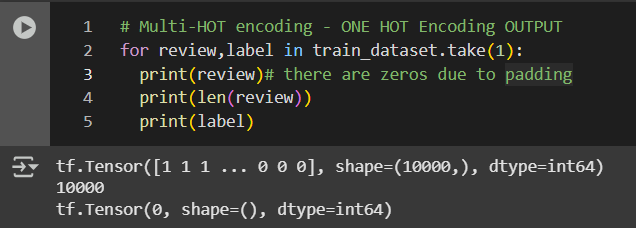

In [26]:
for review,label in train_dataset.take(1):
  print(review)# there are zeros due to padding
  print(len(review))
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

Now we get a numericalized version of our review text

In [27]:
for review, label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [28]:
vectorize_layer.get_vocabulary()[10],vectorize_layer.get_vocabulary()[13],vectorize_layer.get_vocabulary()[33],vectorize_layer.get_vocabulary()[411]

('this', 'was', 'an', 'absolutely')

In [29]:
BATCH_SIZE=64

- Prefetching for efficient loading

    - This code batches the training (train_dataset) and validation (val_dataset) datasets into groups of size BATCH_SIZE for efficient GPU processing and uses prefetch with tf.data.AUTOTUNE to overlap data preprocessing and model execution, improving training speed by loading the next batch of data in the background while the current batch is being processed by the model.

In [30]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modelling


### SimpleRNN

In [31]:
#               [BatchSize,SeqLength,VocabSize]
inputs=np.random.random([32,10,8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25) # output dimension of the SimpleRNN's output will be 25, # dimension of weight
output=simple_rnn(inputs)
print(output.shape)# 32 batches each of dimension 25

(32, 25)


10 words of 8 dimensions each

L1, L2, L3, L4, L5, L6, L7, L8, L9, L10 each of which are 8 dimensional vectors

In [32]:
output

<tf.Tensor: shape=(32, 25), dtype=float32, numpy=
array([[ 6.47815406e-01, -7.43335068e-01, -3.09083790e-01,
        -5.09190917e-01, -8.85993801e-03, -7.00448275e-01,
         7.09453762e-01, -4.79789704e-01, -1.78379282e-01,
        -3.11542392e-01,  6.58399403e-01, -3.62625837e-01,
        -3.27325791e-01,  2.72596598e-01, -3.21820050e-01,
         5.09516656e-01, -2.61251152e-01,  5.13841569e-01,
         3.62398267e-01, -3.57211679e-01, -6.07735962e-02,
         4.33034420e-01, -9.00193930e-01,  5.00781238e-01,
        -1.55686989e-01],
       [ 2.68227488e-01, -4.99616295e-01, -5.48701882e-01,
        -3.44778538e-01, -3.14636767e-01, -6.85897470e-01,
         4.82517093e-01,  3.64255220e-01, -4.82189238e-01,
        -2.40566432e-01,  3.73351157e-01, -5.90523243e-01,
         1.04090743e-01,  7.75465131e-01, -2.88712025e-01,
         6.18371010e-01,  1.48578122e-01,  2.87174940e-01,
         1.16733611e-01,  6.74250871e-02,  2.52173066e-01,
         3.50193530e-01, -9.77159321e-0

* RNN doesn't take in integers

* Embedding layer will take our current integer vector representation and will give floating points

In [33]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)), # we had shape as (250,)
    Embedding(VOCAB_SIZE,EMBEDDING_DIM), # Embedding layer added (Vocab_size->Input dimension ,Embedding Dim->output dimension, what we want our final vectors to be)
    # our input having initially dimension  VOCAB_SIZE will get transformed to EMBEDDING_DIM dimensional vector
    SimpleRNN(32),# output of dimension 32
    Dense(1,activation="sigmoid"), # final output 1 dimensional
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

A checkpoint in deep learning is a saved snapshot of a model’s weights during training, allowing recovery from interruptions or selection of the best-performing version. Here, tf.keras.callbacks.ModelCheckpoint saves the model to rnn.h5 only when validation accuracy (val_accuracy) improves (save_best_only=True), ensuring the final saved model is the one with peak validation performance. The checkpoint is triggered during model.fit(), with the callback monitoring val_accuracy in max mode (maximization). This prevents overfitting by retaining only the optimal weights rather than the last epoch’s state.

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5"
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), # output can be negative or positive review that is binary classification
              optimizer=tf.keras.optimizers.Adam(1e-4),# learning rate
              metrics=['accuracy'])

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,
                  epochs=10,
                  callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4971 - loss: 0.6942

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.4971 - loss: 0.6942 - val_accuracy: 0.4982 - val_loss: 0.6938
Epoch 2/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5406 - loss: 0.6867

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5405 - loss: 0.6867 - val_accuracy: 0.5253 - val_loss: 0.6922
Epoch 3/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5732 - loss: 0.6793

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5731 - loss: 0.6793 - val_accuracy: 0.5279 - val_loss: 0.6936
Epoch 4/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6411 - loss: 0.6505

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.6411 - loss: 0.6504 - val_accuracy: 0.5332 - val_loss: 0.6931
Epoch 5/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7230 - loss: 0.5963

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7230 - loss: 0.5962 - val_accuracy: 0.5521 - val_loss: 0.6898
Epoch 6/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7793 - loss: 0.5357

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7793 - loss: 0.5357 - val_accuracy: 0.5770 - val_loss: 0.6888
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8221 - loss: 0.4694

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8221 - loss: 0.4694 - val_accuracy: 0.5835 - val_loss: 0.7022
Epoch 8/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8547 - loss: 0.4109

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8547 - loss: 0.4108 - val_accuracy: 0.5841 - val_loss: 0.7178
Epoch 9/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8667 - loss: 0.3735

391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8667 - loss: 0.3734 - val_accuracy: 0.5866 - val_loss: 0.7387
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8739 - loss: 0.3508 - val_accuracy: 0.5794 - val_loss: 0.7693


In [ ]:
import matplotlib.pyplot as plt

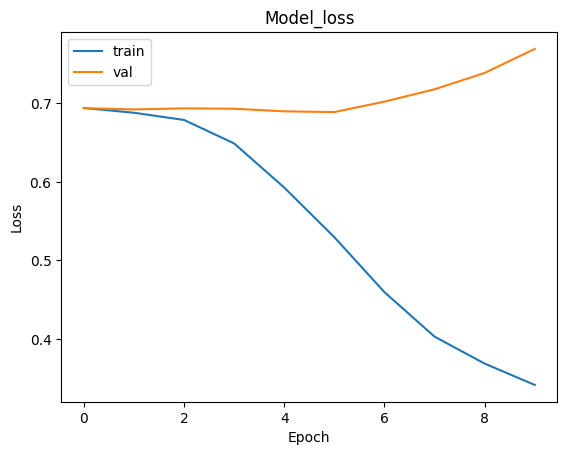

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train','val'],loc='upper left')
plt.show()

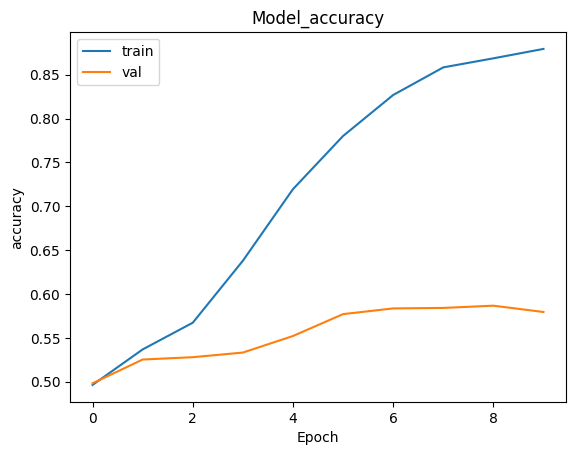

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model_accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(['train','val'],loc='upper left')
plt.show()

As our model's validation loss increase means it is not performing well, also the validation accuracy decreases.

There can be two reasons that our model performed poorly:
1. Vanishing Gradients and Exploding Gradients
2. Problem of Short Term Memory

as we are dealing with sequence length of 250 that is 250 units of Nodes in our RNN layer

So we need long term memory that is LSTM


Vanishing Gradients -
* The gradients of the loss function with respect to the weights become extremely small (close to zero) as they are backpropagated to earlier layers.
* As a result, the weights in early layers update very slowly or not at all, making training ineffective.

Exploding Gradients -
* The gradients grow exponentially large during backpropagation.

* This causes huge weight updates, leading to numerical instability (e.g., NaN errors).

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5736 - loss: 0.7715


[0.7695674300193787, 0.5738400220870972]

## LSTM (MultiLayer and Bidirectional)

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation="sigmoid"),

])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5"
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[model_checkpoint_callback])

Epoch 1/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5394 - loss: 0.6806

391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.5399 - loss: 0.6803 - val_accuracy: 0.8115 - val_loss: 0.4219
Epoch 2/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8494 - loss: 0.3720

391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - accuracy: 0.8495 - loss: 0.3718 - val_accuracy: 0.8598 - val_loss: 0.3355
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9062 - loss: 0.2560 - val_accuracy: 0.8594 - val_loss: 0.3553
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9283 - loss: 0.2092 - val_accuracy: 0.8570 - val_loss: 0.3862
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9379 - loss: 0.1873 - val_accuracy: 0.8521 - val_loss: 0.4052
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9394 - loss: 0.1777 - val_accuracy: 0.8559 - val_loss: 0.3937
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9488 - loss: 0.1583 - val_accuracy: 0.8513 - val_loss: 0.4137
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9586 - loss: 0.1296 - val_accuracy: 0.8396 - val_loss: 0.4603
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9657 - loss: 0.1169 - val_accurac

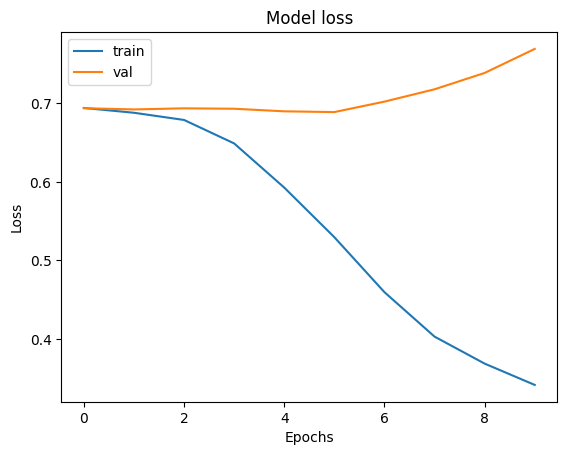

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper left')
plt.show()

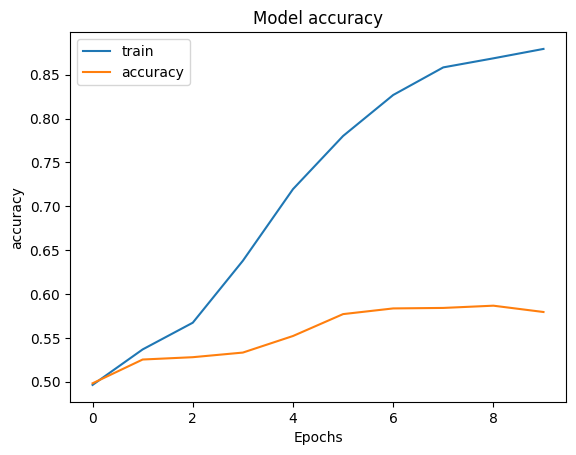

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train','accuracy'],loc='upper left')
plt.show()

Evaluation

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8475 - loss: 0.5045


[0.5000413060188293, 0.8490399718284607]

## GRU(Multilayer and Bidrirectional)

In [29]:
from tensorflow.keras.layers import GRU

In [30]:
import tensorflow as tf

In [31]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(64,activation="relu"),
    Dropout(0.5),
    Dense(1,activation='relu')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train','accuracy'],loc='upper left')
plt.show()

## Conv1D

In [33]:
from tensorflow.keras.layers import Conv1D, Flatten, Dropout

In [35]:
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,),dtype='int64'),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Conv1D(32,3,activation="relu"),
    Flatten(),
    Dense(32,activation="relu"),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 248, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       253,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,193 (3.43 MB)

 Trainable params: 900,193 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train','accuracy'],loc='upper left')
plt.show()

## Word2Vec

In [1]:
!pip install gensim

In [3]:
word2vec=api.load("word2vec-google-news-300") # 300->embedding dimension

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [2]:
import gensim.downloader as api

In [39]:
from numpy import random

In [54]:
pretrained_embeddings=[]


In [44]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [58]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('i is====================================',i)


nosolution
i is==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
i is==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
i is==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
i is===============

In [60]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
np.save("/content/drive/MyDrive/nlp/sentiment_analysis",pretrained_embeddings_array)

In [4]:
print(word2vec.vectors.shape)

(3000000, 300)


In [5]:
print(word2vec.most_similar("Car"))

[('car', 0.6677608489990234), ('Auto', 0.6563326716423035), ('Vehicle', 0.6293455362319946), ('Cars', 0.6291522979736328), ('##V_Midsize_Car', 0.621805727481842), ('Truck', 0.619486391544342), ('##V_MPFI_OHV_Midsize', 0.6166540384292603), ('##V_MPFI_SOHC_Midsize', 0.5996174216270447), ('Motorbike', 0.596684992313385), ('##V_MPFI_DOHC_Compact', 0.5942220091819763)]


In [6]:
len(word2vec['Notice']) #

300

In [7]:
pretrained_embeddings=[]

In [8]:
def first_caps(word):
  return word[0].upper()+word[1:]

Look for the vocabulary of our problem inside the pretrained_embeddings vocab list

In [ ]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
  if i%1000==0:
    print("i is===",i)


In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential(
    [
        Input(shape=(SEQUENCE_LENGTH,)),
        Embedding(
            VOCAB_SIZE,
            EMBEDDING_DIM,
            embedding_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
            trainable=True
        ),
        Conv1D(32,3,activation='relu'),
        Flatten(),
        Dense(32,activation='relu'),
        Dropout(0.5),
        Dense(1,activation='sigmoid')
    ]
)
model.summary()

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[model_checkpoint,callback])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train','accuracy'],loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
